# MS-80 Cost Prediction 

This is my first attempt at using machine learning and scikit-learn on my own data. I put the code together here by searching for similar analyses that I could combine and adapt for my dataset.  My resources are listed at the end of this notebook.  

I took the following steps:
1. Imported data from excel and shaped into a dataframe with the variables I wanted to investigate.
2. Scatterplotted to check for skew.
3. Decided to use a logarithmic transformation.
4. Performed linear regression and decided to drop one variable because it did not affect the root mean squared error (RMSE.)
5. Split the data set into train/test for linear regression.
6. Checked a plot of the residuals from the train/test sets.

I'm still learning the limitations for these concepts, I'm not certain yet each step is appropriate for my particular dataset. However, it's a starting place, and I'll continue to dig into my assumptions as I iterate.

## Background

The MS-80 is a dewatering machine that separates sewage solids from water. Each time we run a "batch" it costs a different amount, depending on the inputs and the length of the run.  Usually the cost is calculated retroactively, I wanted to experiment and see if it could be predicted from the input variables. 

## Import data from excel, select relevant data

In [1]:
import pandas as pd

# Open excel file as object
all = pd.ExcelFile('MS80 POLY Q3-2016-clean.xlsx')

# Parse sheet named "raw data" as DataFrame
raw = all.parse('raw data', skiprows=4, na_values=['NA'])

# Preview first 3 rows of dataframe
raw.head(3)

,Batch Name,Experimental notes,Total cost $/ ton DS,Tank prep $/ton DS,MS80 labor $/ton DS,Polymer $/ton DS,Electricity $/ton DS,kg DS in cake,Unnamed: 8,kg DS/m3 sewage,...,AUGER SPEED,Belt speed,INFLUENT RATING,EFFLUENT RATING,CAKE RATING,wedgewire used,door,"Experiment rating, Good-Medium-Bad","DO, mg/L",Temp. oC
0,16jul05tp1,"1st Experiment with screen in reservoir, High %TS",51.389118,3.581734,13.371807,26.449728,7.985849,136.107258,NaN,18.147634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16jul05tp2,"1st Experiment with screen in reservoir, High %TS",52.218569,4.094865,12.284596,28.223071,7.616037,119.051538,NaN,17.007363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16jul07hp1,NaN,249.936817,22.856480,77.712032,104.647515,44.720790,21.328743,NaN,1.720060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Select relevant columns for a new dataframe
ms80 = raw[[0, 2, 11, 23, 12]]

# Rename columns
ms80.columns = ['batch', 'cost', 'inlet_ts', 'dose', 'time']

# Drop NaN rows
ms80 = ms80.dropna()

ms80.head(3)

,batch,cost,inlet_ts,dose,time
0,16jul05tp1,51.389118,1.21,16.0,56
1,16jul05tp2,52.218569,1.03,16.0,45
2,16jul07hp1,249.936817,1.37,6.0,51


The MS80 process and the way that we measured it changed substantially during July-Sept.  I'm only going to use the data from Oct-Sept when operations were in more of a steady state.

In [3]:
# Change all batchnames to be lower case only
ms80.loc[:,('batch')] = map(lambda x: x.lower(), ms80.loc[:,'batch'])

# Filter for batches from Oct-Dec
oc = ms80.batch.str.contains('oc')
nov = ms80.batch.str.contains('nov')
dec = ms80.batch.str.contains('dec')

ms80 = ms80[oc | nov | dec]

ms80.head(3)


,batch,cost,inlet_ts,dose,time
446,16oct06hp1,68.969556,0.813416,4.0,22
447,16oct06hp2,93.885347,2.608092,4.0,25
448,16oct06hp3,27.273971,1.681416,3.0,32


## Plotting and transforming data

Great, now we've got the data we need in a dataframe.  What does it look like?

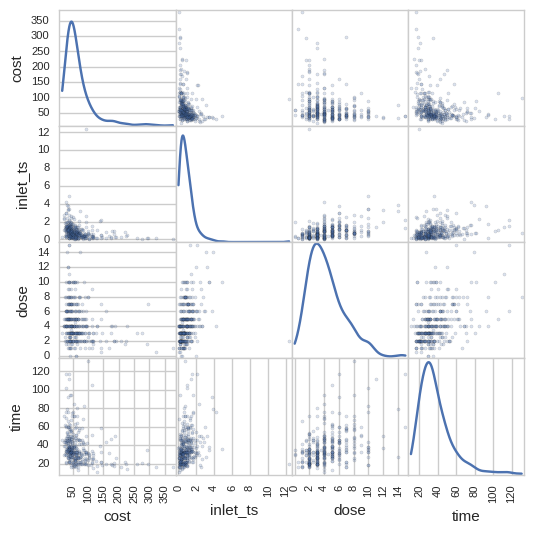

In [4]:
# Imports for plots
import matplotlib.pyplot as plt
import numpy as np
from pandas.tools.plotting import scatter_matrix

import seaborn as sns
sns.set_style('whitegrid')

# Put plots directly into jupyter notebook
%matplotlib inline

scatter_matrix(ms80, alpha=0.2, figsize=(6, 6), diagonal='kde');



**Observations:** All of the variables seem skewed to the left and "look" exponential.  They won't fit a linear regression model very well.  

**Assumption:** Taking the log of all variables will help them fit a linear shape.


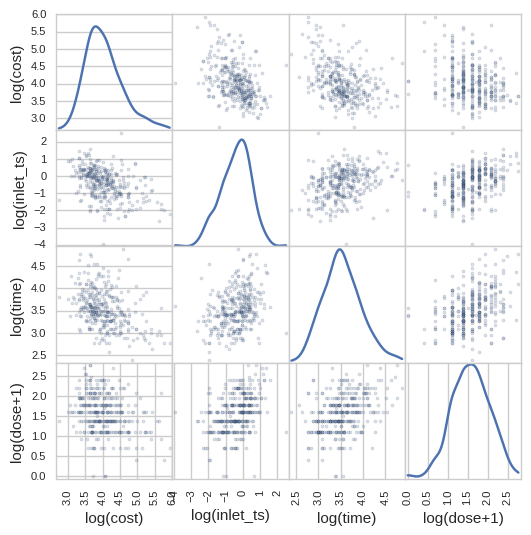

In [5]:
# Take the log of three variables
ms80_log = np.log(ms80[['cost', 'inlet_ts', 'time']])

# Dose has 3 values that are zero, where no dose was used
# These values should be kept, but log(0) = inf 
# log(1) = 0, which is better
# So I'll add one before taking the log, so those values are not lost
ms80_log['dose']= ms80.dose +1
ms80_log.dose = np.log(ms80_log['dose'])

# Rename columns for plot
ms80_log.columns = ['log(cost)', 'log(inlet_ts)', 'log(time)', 'log(dose+1)']

scatter_matrix(ms80_log, alpha=0.2, figsize=(6, 6), diagonal='kde');

# Simple histogram
#plt.hist(cost_log, bins = 'auto');



**Observations:** Each variable now has more of a normal distribution, and "looks" like a better fit for linear regression.

**Questions to investigate in the next version:**
* What are the caveats and limitations of using a log transform?
* Should all the variables be log transformed?  The distribution of "dose" is not as extreme as the others.
* Under what circumstances is it not appropriate to log transform?
* Is it appropriate to add 1 only to the variable with zero values in it and not to the other variables?

## Linear Regression with All Data

In [6]:
# Rename columns to make them easier to use as variables
ms80_log.columns = ['cost', 'ts', 'time', 'dose']

In [7]:
# Import for linear regression
import sklearn
from sklearn.linear_model import LinearRegression

# Create linear regression object
lr = LinearRegression()

# Separate into target and data columns
y_target = ms80_log.cost

# Data, drop cost columns... axis=1 is to drop column, not row
x_data = ms80_log.drop(['cost'], axis=1)

# Implement Linear Regression
lr.fit(x_data, y_target)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
# Create a DataFrame of the coefficients
coeffs = pd.DataFrame(x_data.columns)
coeffs.columns = ['Features']

# Create new column with coefficients from linear regression
coeffs["Coefficient"] = pd.Series(lr.coef_)

coeffs

,Features,Coefficient
0,ts,-0.198226
1,time,-0.354090
2,dose,-0.032222


**Observations:** Dose is an order of magnitude smaller than the other coefficients, even though all of the log transformed features themselves lie roughly in the same order of magnitude.

What is the effect on RMSE when dose is dropped from the regression?

## Linear Regression without Dose

In [10]:
# We need to calculate RMSE with dose included, first
from sklearn import metrics

# Predict y, given an x that includes the dose
y_pre_dose = lr.predict(x_data)

# Calculate the RMSE
dose_rmse = np.sqrt(metrics.mean_squared_error(y_target, y_pre_dose))

# Drop dose column
x_no_dose = x_data.drop(['dose'], axis=1)

# Implement Linear Regression
lr.fit(x_no_dose, y_target)

# Create a DataFrame of the coefficients
coeffs = pd.DataFrame(x_no_dose.columns)
coeffs.columns = ['Features']

# Create new column with coefficients from linear regression
coeffs["Coefficient"] = pd.Series(lr.coef_)

coeffs



,Features,Coefficient
0,ts,-0.203473
1,time,-0.364363


In [11]:
# Predict y, given an x that excludes the dose
y_pre_no_dose = lr.predict(x_no_dose)

# Calculate the RMSE
no_dose_rmse =  np.sqrt(metrics.mean_squared_error(y_target, y_pre_no_dose))

print "Fit a model with dose, calculate RSME: ", dose_rmse
print "Fit a model with no dose, calculate RSME: ", no_dose_rmse

Fit a model with dose, calculate RSME:  0.464423147186
Fit a model with no dose, calculate RSME:  0.464621831122


The RMSE improves very slightly when dose is dropped, but basically the RMSE's are identical.  So dose can likely be excluded from the model.

## Linear Regression with Test Train Split

Split the data into training and testing sets.

In [12]:
from sklearn.cross_validation import train_test_split

# Set x_data to exclude the dose, since it did not have a large effect above
x_data = x_no_dose

# Set the random generator seed for the test/train split
# Set it to the answer to life, the universe, and everything
seed = 42

# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((249, 2), (84, 2), (249,), (84,))


In [13]:
# Create linear regression object, run a fit on training data
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
# Run prediction on training and testing sets
y_train_pre = lr.predict(x_train)
y_test_pre = lr.predict(x_test)

In [15]:
# Calculate Root Mean Squared Error
train_rmse =  np.sqrt(metrics.mean_squared_error(y_train, y_train_pre))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pre))

print "Fit a model will all data, calculate RMSE: ", no_dose_rmse
print "Fit a model with x_train, calculate RMSE with y_train: ", train_rmse
print "Fit a model with x_train, calculate RMSE with x_test, y_test: ", test_rmse


Fit a model will all data, calculate RMSE:  0.464621831122
Fit a model with x_train, calculate RMSE with y_train:  0.474717182396
Fit a model with x_train, calculate RMSE with x_test, y_test:  0.433818594821


**Observations:** 
* The RMSE from training and testing are reasonably close to each other
* ...but, of course the difference between the RSME's changes depending on the random seed that splits test/train. 

**Questions that are important to investigate in the next version:**
* Just out of curiousity, write a for loop to compare the difference in train/test RMSE for different random seeds.  How much does the difference between them vary?
* Are there other models or regressions I could compare that more reliably have a closer RMSE across different train/test random seeds?

## Plot the Residuals

Check to see that the residuals are randomly scattered and do not have a pattern.

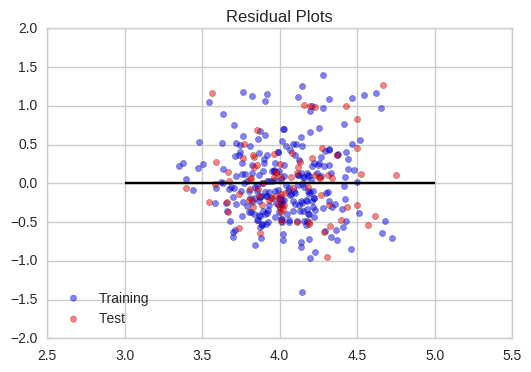

In [16]:
# Scatter plot training data
train = plt.scatter(y_train_pre,(y_train-y_train_pre),c='b',alpha=0.5)

# Scatter plot testing data
test = plt.scatter(y_test_pre,(y_test-y_test_pre),c='r',alpha=0.5)

# Plot a horizontal axis line at 0
plt.hlines(y=0,xmin=3,xmax=5)

#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots');

Yup, the residuals look randomly distributed. Yay!

## Next Steps
* What other types of machine learning or regression might be appropriate for this data set?
* Could inlet_ts and time be used at the factory to give an approximation of batch cost?
* It might make more sense to use dose and time since those are fast measurements.  Can dose be used in place of inlet_ts and time?
* Are there other variables from the original excel data that could make the fit better?

## Resources

I borrowed code and ideas from the following places:

https://github.com/justmarkham/DAT5/blob/master/notebooks/09_linear_regression.ipynb

http://nbviewer.jupyter.org/github/jmportilla/Udemy---Machine-Learning/blob/master/Supervised%20Learning%20-%20%20Linear%20Regression.ipynb

http://www.kenbenoit.net/courses/ME104/logmodels2.pdf